In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import optimizer

import matplotlib.pyplot as plt
pd.options.display.max_columns = None
pd.options.display.max_rows = 50
pd.options.display.min_rows = 20

%matplotlib notebook

In [2]:
crop_yield_data = pd.read_csv('yield_forecasting_database_0718.csv', parse_dates=['Date', ], dayfirst=True)
crop_yield_data = crop_yield_data.sort_values('Date')

In [3]:
crop_yield_data.keys()

Index(['Unnamed: 0', 'Vineyard_name', 'Block_name', 'Season', 'Date',
       'Variety', 'NDVImean', 'NDVIsum', 'NDWImean', 'NDWIsum', 'NDVIRemean',
       'NDVIResum', 'TCARImean', 'TCARIsum', 'SIPImean', 'SIPIsum',
       'RRENDVImean', 'RRENDVIsum', 'RN2NDVImean', 'RN2NDVIsum', 'GNDVImean',
       'GNDVIsum', 'MSRmean', 'MSRsum', 'RVImean', 'RVIsum', 'N2NDVImean',
       'N2NDVIsum', 'RENDVI1mean', 'RENDVI1sum', 'RENDVI2mean', 'RENDVI2sum',
       'RDVI1mean', 'RDVI1sum', 'RDVI2mean', 'RDVI2sum', 'TDVImean', 'TDVIsum',
       'TDVI2mean', 'TDVI2sum', 'NLImean', 'NLIsum', 'LAIGmean', 'LAIGsum',
       'SMmean', 'SMsum', 'GDD', 'Rainfall', 'Yield', 'Size', 'Ha',
       'SizeClass', 'TimeTo', 'BlockAverage', 'VineyardVarietyAverage',
       'HeatShock', 'FrostShock', 'MaxSize', 'PC1', 'PC2',
       'Cabernet Sauvignon', 'Chardonnay', 'Marzemino', 'Merlot', 'Pinot Gris',
       'Pinot Noir', 'Rare Red', 'Rare White', 'Riesling', 'Sauvignon Blanc',
       'Sauvignon Gris', 'Syrah', 'Yield

In [183]:
from scipy.stats import norm
def gaussianize(data):
    n = data.shape[0]
    indices = np.argsort(data)
    qs = norm.ppf(np.linspace(1/n, 1 - 1/n, n))
    return qs[indices]

crop_yield_data['YieldGaussian'] = gaussianize(crop_yield_data.Yield.to_numpy())
crop_yield_data['YieldPerHecGaussian'] = gaussianize(crop_yield_data.YieldPerHec.to_numpy())

<IPython.core.display.Javascript object>


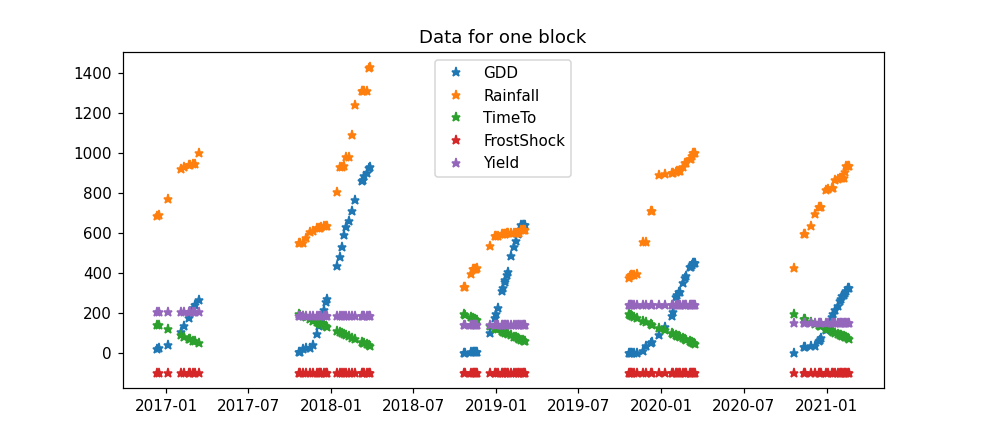

Text(0.5, 1.0, 'Data for one block')

In [182]:
%matplotlib notebook

data_block = crop_yield_data[crop_yield_data.Block_name == 'QB7WVWW'].sort_values('Date')

plt.figure(figsize=(9, 4))
plt.plot(data_block.Date.to_numpy(), data_block.GDD.to_numpy(), '*', label='GDD')
plt.plot(data_block.Date.to_numpy(), data_block.Rainfall.to_numpy(),  '*', label='Rainfall')

plt.plot(data_block.Date.to_numpy(), data_block.TimeTo.to_numpy(),  '*', label='TimeTo')
#plt.plot(data_block.Date.to_numpy(), data_block.NDWIsum.to_numpy(),  '*', label='NDWIsum')
plt.plot(data_block.Date.to_numpy(), data_block.FrostShock.to_numpy() * 100, '*', label='FrostShock')

plt.plot(data_block.Date.to_numpy(), data_block.Yield.to_numpy() * 10,  '*', label='Yield')

plt.legend()
plt.title('Data for one block')

## Cumulative quantities 

We define cumulative quantities over the season

In [5]:
def add_cumulative(data: pd.DataFrame, feature_name: str):
    cumulative_feature = crop_yield_data.groupby(['Season', 'Block_name'])[feature_name].cumsum()
    data['cml_' + feature_name] = cumulative_feature



In [274]:
cumulative_features = [
       'NDVImean', 'NDVIsum', 'NDWImean', 'NDWIsum', 'NDVIRemean',
       'NDVIResum', 'TCARImean', 'TCARIsum', 'SIPImean', 'SIPIsum',
       'RRENDVImean', 'RRENDVIsum', 'RN2NDVImean', 'RN2NDVIsum', 'GNDVImean',
       'GNDVIsum', 'MSRmean', 'MSRsum', 'RVImean', 'RVIsum', 'N2NDVImean',
       'N2NDVIsum', 'RENDVI1mean', 'RENDVI1sum', 'RENDVI2mean', 'RENDVI2sum',
       'RDVI1mean', 'RDVI1sum', 'RDVI2mean', 'RDVI2sum', 'TDVImean', 'TDVIsum',
       'TDVI2mean', 'TDVI2sum', 'NLImean', 'NLIsum', 'LAIGmean', 'LAIGsum',
       'SMmean', 'SMsum', 
        'GDD', 'Rainfall'
]

for feature in cumulative_features:
    add_cumulative(crop_yield_data, feature)

## Basic model 

In [363]:
N_EPOCHS = 100
BATCH_SIZE = 1024
DEVICE = 'cuda:0'

For our first model we will only use a handfull of features, specifically:
1. GDD: this indicator is related to the amount of sun
2. Rainfall: indicator for the amount of rain
3. TimeTo: time until harvesting
4. HeatShock, Frostshock: indicators of temperature shocks
5. High yield / Low yield: important feature as it determines the method of growth

In [364]:
feature_names = ['GDD', 'Rainfall', 'High yield',
                 'TimeTo', 
                 #'FrostShock', 
                 'HeatShock',
                'MaxSize', 'Size',
                'NDVImean', 'NDVIsum', 'NDWImean', 'NDWIsum', 'NDVIRemean',
               'NDVIResum', 'TCARImean', 'TCARIsum', 'SIPImean', 'SIPIsum',
               'RRENDVImean', 'RRENDVIsum', 'RN2NDVImean', 'RN2NDVIsum', 'GNDVImean',
               'GNDVIsum', 'MSRmean', 'MSRsum', 'RVImean', 'RVIsum', 'N2NDVImean',
               'N2NDVIsum', 'RENDVI1mean', 'RENDVI1sum', 'RENDVI2mean', 'RENDVI2sum',
               'RDVI1mean', 'RDVI1sum', 'RDVI2mean', 'RDVI2sum', 'TDVImean', 'TDVIsum',
               'TDVI2mean', 'TDVI2sum', 'NLImean', 'NLIsum', 'LAIGmean', 'LAIGsum',
               'SMmean', 'SMsum',
                'Cabernet Sauvignon', 'Chardonnay', 'Marzemino', 'Merlot', 'Pinot Gris',
                'Pinot Noir', 'Rare Red', 'Riesling', 'Sauvignon Blanc', 'Sauvignon Gris',
                'Syrah',
                ]

feature_names.extend(['_'.join(('cml', f_name)) for f_name in cumulative_features])
print(feature_names)

['GDD', 'Rainfall', 'High yield', 'TimeTo', 'HeatShock', 'MaxSize', 'Size', 'NDVImean', 'NDVIsum', 'NDWImean', 'NDWIsum', 'NDVIRemean', 'NDVIResum', 'TCARImean', 'TCARIsum', 'SIPImean', 'SIPIsum', 'RRENDVImean', 'RRENDVIsum', 'RN2NDVImean', 'RN2NDVIsum', 'GNDVImean', 'GNDVIsum', 'MSRmean', 'MSRsum', 'RVImean', 'RVIsum', 'N2NDVImean', 'N2NDVIsum', 'RENDVI1mean', 'RENDVI1sum', 'RENDVI2mean', 'RENDVI2sum', 'RDVI1mean', 'RDVI1sum', 'RDVI2mean', 'RDVI2sum', 'TDVImean', 'TDVIsum', 'TDVI2mean', 'TDVI2sum', 'NLImean', 'NLIsum', 'LAIGmean', 'LAIGsum', 'SMmean', 'SMsum', 'Cabernet Sauvignon', 'Chardonnay', 'Marzemino', 'Merlot', 'Pinot Gris', 'Pinot Noir', 'Rare Red', 'Riesling', 'Sauvignon Blanc', 'Sauvignon Gris', 'Syrah', 'cml_NDVImean', 'cml_NDVIsum', 'cml_NDWImean', 'cml_NDWIsum', 'cml_NDVIRemean', 'cml_NDVIResum', 'cml_TCARImean', 'cml_TCARIsum', 'cml_SIPImean', 'cml_SIPIsum', 'cml_RRENDVImean', 'cml_RRENDVIsum', 'cml_RN2NDVImean', 'cml_RN2NDVIsum', 'cml_GNDVImean', 'cml_GNDVIsum', 'cml_MS

In [365]:
crop_yield_data['YieldPerHec_log'] = np.log(crop_yield_data.YieldPerHec)
crop_yield_data['YieldPerHec_log_n'] = (crop_yield_data.YieldPerHec_log - crop_yield_data.YieldPerHec_log.mean()) / crop_yield_data.YieldPerHec_log.std()

In [366]:
crop_yield_data.FrostShock = crop_yield_data.FrostShock.fillna(-5)
crop_yield_data.HeatShock = crop_yield_data.HeatShock.fillna(-5)

In [381]:
from typing import List
from datetime import datetime
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from tukey.losses import TuckeyGandHloss

def convert_dataset_to_tensor(pd_data: pd.DataFrame, feature_names: List[str], target_name: str,
                             log_target: bool = True, mean_features: float = None,
                              std_features: float = None):
    features = pd_data[feature_names]
    targets = pd_data[target_name]
    features_torch = torch.from_numpy(features.to_numpy()).to(dtype=torch.float32)
    targets_torch = torch.from_numpy(targets.to_numpy()).to(dtype=torch.float32)
    # apply transformations
    if log_target:
        targets_torch = torch.log(targets_torch)
    else:
        pass
        #targets_torch = (targets_torch - 200) / 100
    targets_torch = torch.reshape(targets_torch, ((-1, 1)))
    
    # compute mean and std for training data
    if mean_features is None:
        mean = torch.mean(features_torch, dim=0, keepdim=True)
        std = torch.std(features_torch, dim=0, keepdim=True)
        features_torch = (features_torch - mean) / std
        return (features_torch, targets_torch), (mean, std)
    # for new data apply mean and std from train data
    features_torch = (features_torch - mean_features) / std_features
    return features_torch, targets_torch


def split_train_test(pd_data: pd.DataFrame, split_date: str):
    split_date = datetime.fromisoformat(split_date)
    train, test = pd_data[pd_data.Date <= split_date], pd_data[pd_data.Date > split_date]
    return train, test


class NN(Sequential):
    def __init__(self, structure: list, n_out: int):
        subblocks = []
        self.n_out = n_out
        for i in range(len(structure) - 1):
            subblocks.extend(self._make_sublock(structure[i], structure[i + 1]))
        subblocks.extend(self._make_final_layer(structure[-1]))
        super().__init__(*subblocks)

    def _make_sublock(self, n_in: int, n_out: int):
        return [Linear(n_in, n_out), BatchNorm1d(n_out, affine=False), ReLU()]

    def _make_final_layer(self, n_in : int):
        return [Linear(n_in, self.n_out), ]


def train_for_one_epoch(nn, loss, optimizer, scheduler, train_dataset: Dataset, val_dataset: Dataset):
    nn.train()
    dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    losses = []
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = nn(x)
        loss_y_yhat = loss(y_hat, y)
        loss_y_yhat.backward()
        optimizer.step()
        losses.append(loss_y_yhat.detach().item())
    scheduler.step()
    print('Train losses: ', np.mean(losses))
    
    nn.eval()
    dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    losses = []
    losses_gaussian = []
    ys, mus = [], []
    with torch.no_grad():
        for x, y in dataloader_val:
            y_hat = nn(x)
            loss_y_yhat = loss(y_hat, y)
            pred_mu, _ = loss.predict_ci(y_hat, 0.001)
            mus.append(torch.exp(pred_mu))
            ys.append(torch.exp(y))
            losses.append(loss_y_yhat.detach().item())
    ys = torch.cat(ys)
    mus = torch.cat(mus)
    rmse = torch.sqrt(torch.mean(ys - mus)**2)
    print('Validation losses: ', np.mean(losses), f'RMSE: {rmse}')

In [384]:
train = crop_yield_data[crop_yield_data.Season < 2020]
test = crop_yield_data[crop_yield_data.Season == 2020]

train_torch, mean_std = convert_dataset_to_tensor(train, feature_names, 'YieldPerHec_log', False)
test_torch = convert_dataset_to_tensor(test, feature_names, 'YieldPerHec_log', False, *mean_std)

# add some noise
train_torch = (train_torch[0] + torch.randn_like(train_torch[0]) * 0.,
               train_torch[1] + torch.randn_like(train_torch[1]) * 0.0)

train_torch[0].shape, train_torch[1].shape

(torch.Size([26926, 100]), torch.Size([26926, 1]))

In [385]:
from torch.optim import Adam, SGD
nn = NN((len(feature_names), 32, 32, 32, 32, 32, 32, 32), 4)  # 4 outputs required for G-and-H

In [386]:
from torch.optim.lr_scheduler import StepLR, CyclicLR
optimizer = Adam(nn.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=50)
#scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=10)


In [387]:
torch.any(torch.isnan(train_torch[0]))

tensor(False)

Train losses:  1.5425388125272899
Validation losses:  1.8096969777887517 RMSE: 0.9000284671783447


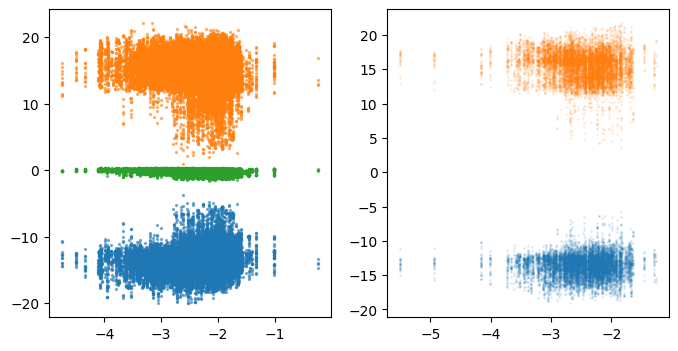

Train losses:  1.043717161967204
Validation losses:  1.0373615134846081 RMSE: 0.5056859850883484


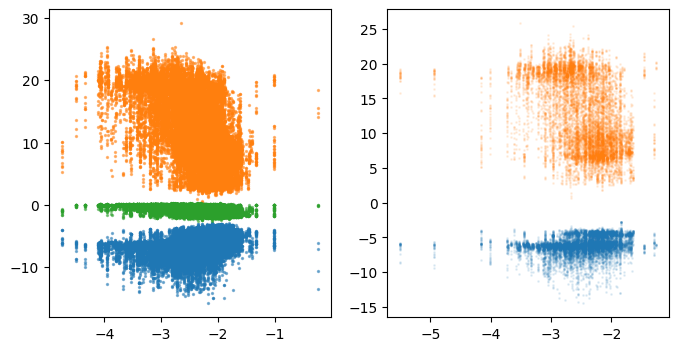

Train losses:  0.5894432675379974
Validation losses:  0.539991861039942 RMSE: 0.2486315220594406


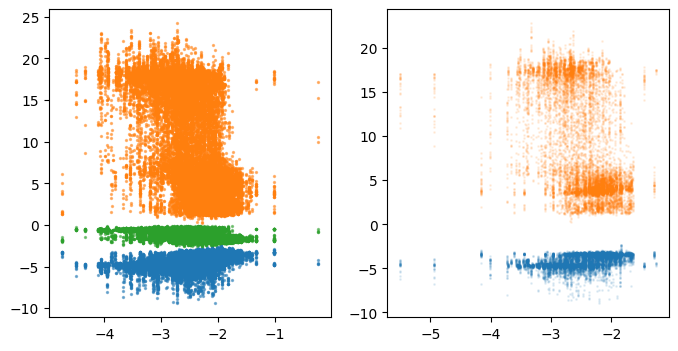

Train losses:  0.21980695612728596
Validation losses:  0.25218257308006287 RMSE: 0.11535268276929855


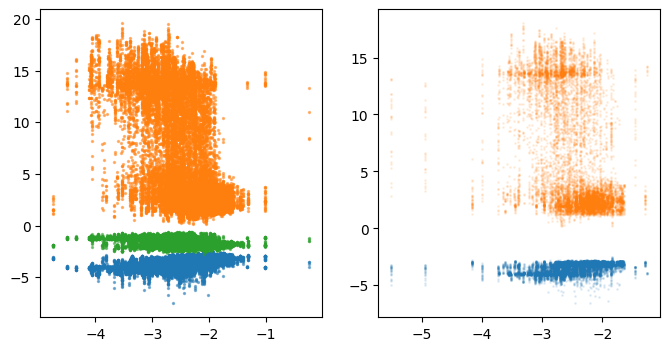

Train losses:  -0.0508674553488023
Validation losses:  0.048946084793318405 RMSE: 0.048258233815431595


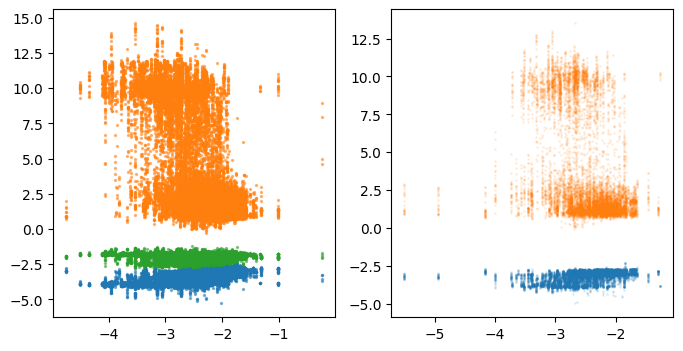

Train losses:  -0.24263989352262938
Validation losses:  -0.0441031168976968 RMSE: 0.024680955335497856


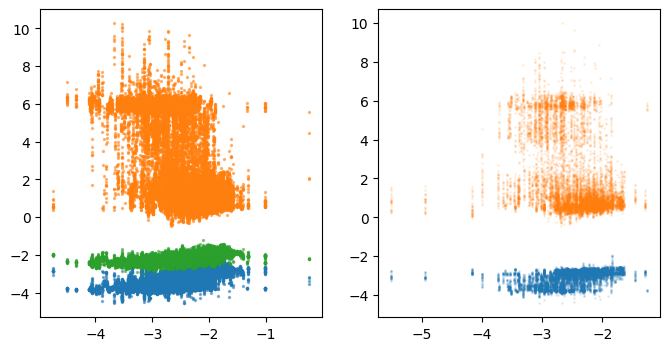

Train losses:  -0.3547294976619574
Validation losses:  -0.019536642103709957 RMSE: 0.018631987273693085


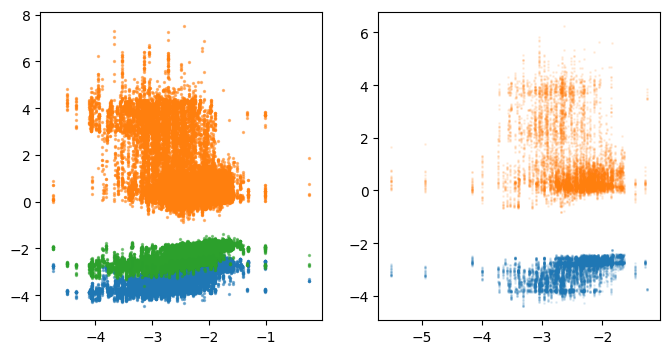

Train losses:  -0.4229553284553381
Validation losses:  -0.08429658853194931 RMSE: 0.013307872228324413


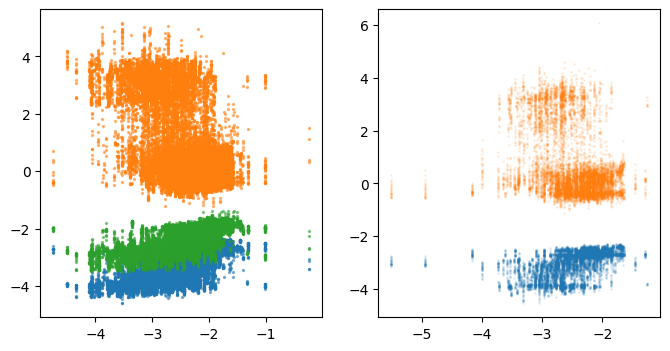

Train losses:  -0.4819881789959394
Validation losses:  -0.11977915635163133 RMSE: 0.010969524271786213


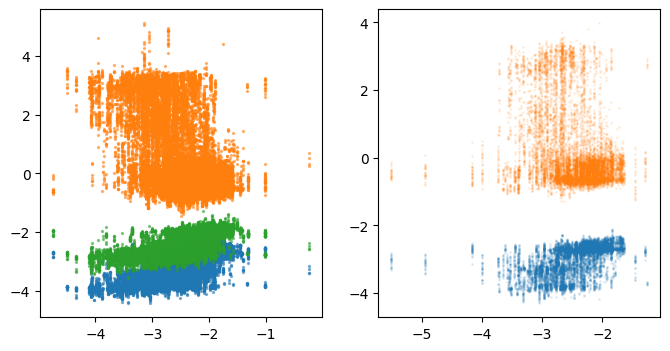

Train losses:  -0.5280758325870221
Validation losses:  -0.16235124658454547 RMSE: 0.008829381316900253


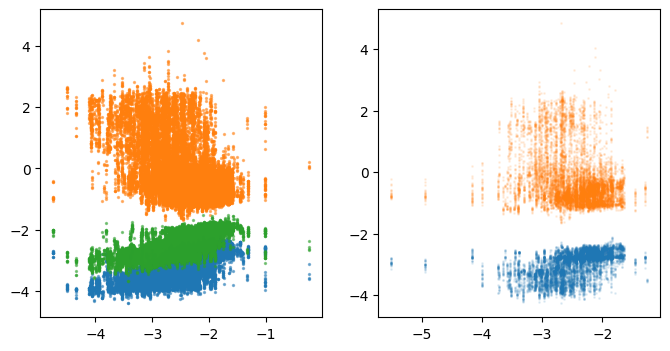

Train losses:  -0.573835742015105
Validation losses:  -0.1785975071516904 RMSE: 0.00991801731288433


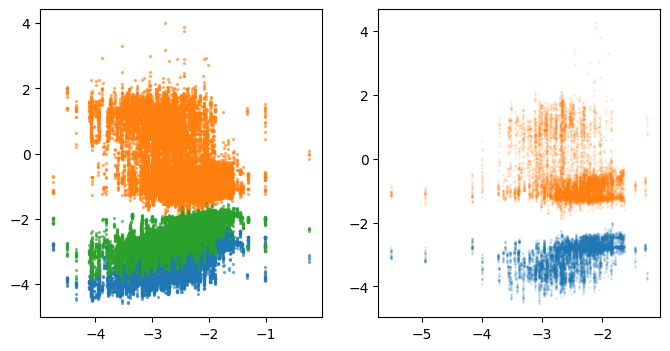

Train losses:  -0.6197373202213874
Validation losses:  -0.14504839852452278 RMSE: 0.009694797918200493


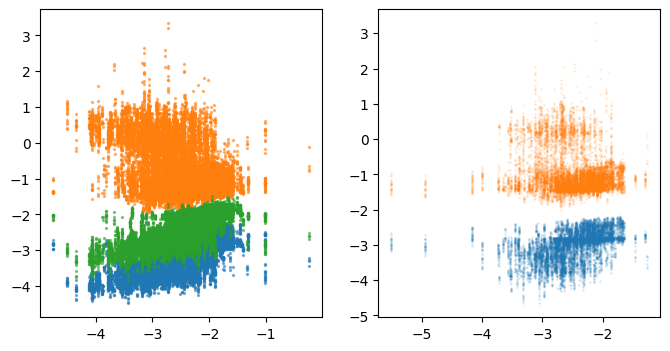

Train losses:  -0.6649421178377591
Validation losses:  -0.1623222716152668 RMSE: 0.009815321303904057


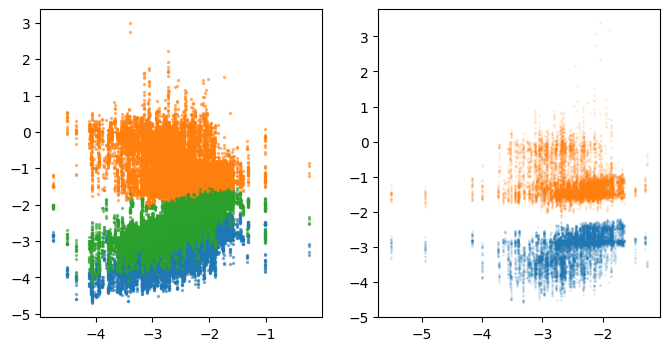

Train losses:  -0.7042509294473208
Validation losses:  -0.25847282192923804 RMSE: 0.007252188865095377


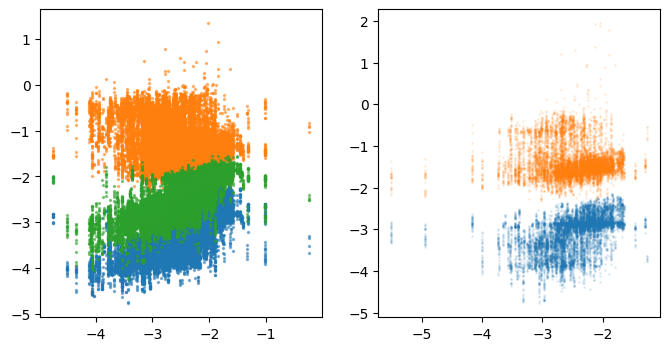

Train losses:  -0.7405726519914774
Validation losses:  -0.24633691798556934 RMSE: 0.005290968809276819


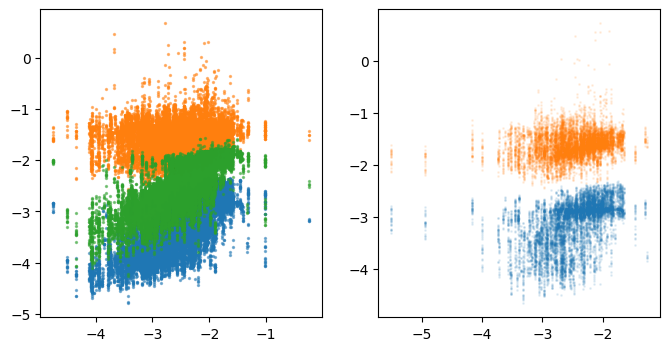

Train losses:  -0.7645438886605777
Validation losses:  -0.20786780525337567 RMSE: 0.007707260083407164


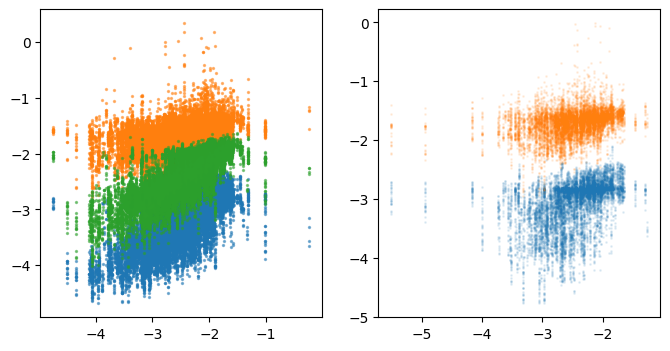

Train losses:  -0.7629329516337469
Validation losses:  -0.22346436977386475 RMSE: 0.007143468130379915


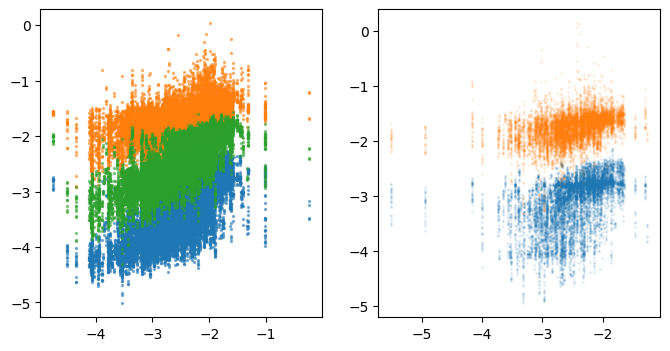

Train losses:  -0.792602403805806
Validation losses:  -0.17012304067611694 RMSE: 0.0038516151253134012


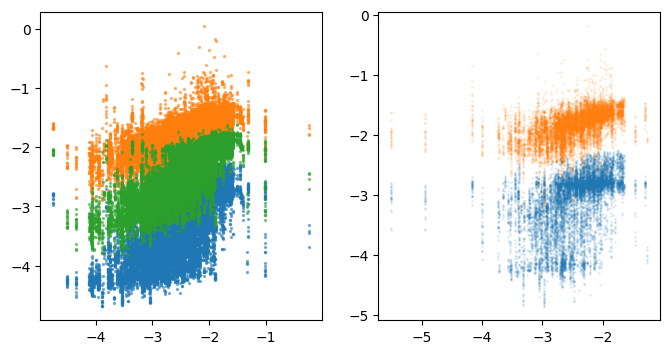

Train losses:  -0.7937739422688117
Validation losses:  -0.13468356430530548 RMSE: 0.00714128278195858


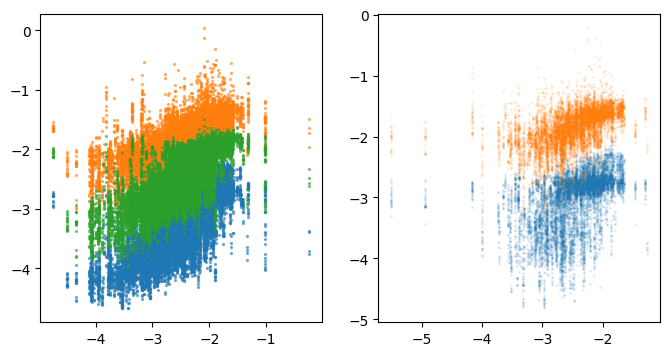

Train losses:  -0.8163287685467646
Validation losses:  -0.09257208149541508 RMSE: 0.0018948449287563562


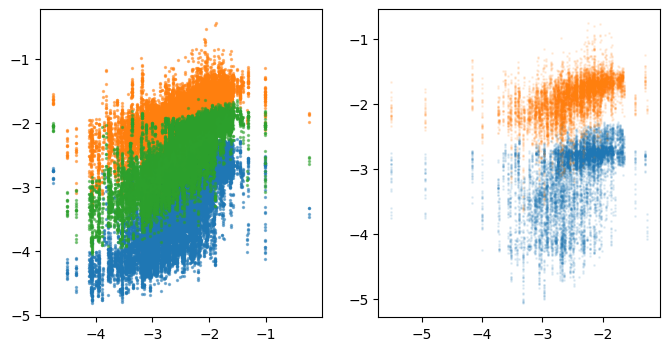

Train losses:  -0.8270145562978891
Validation losses:  0.1323775601657954 RMSE: 0.005620252341032028


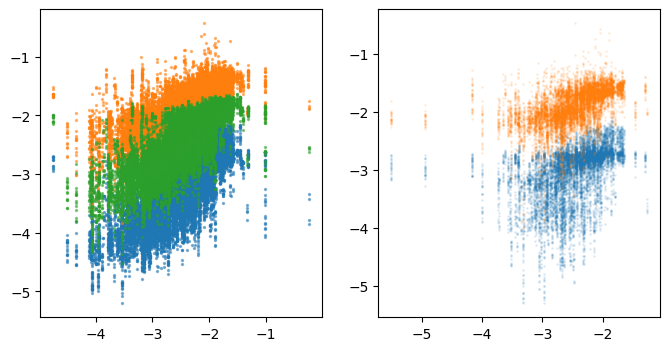

Train losses:  -0.8308503467303056
Validation losses:  0.03724477711048993 RMSE: 0.007475704420357943


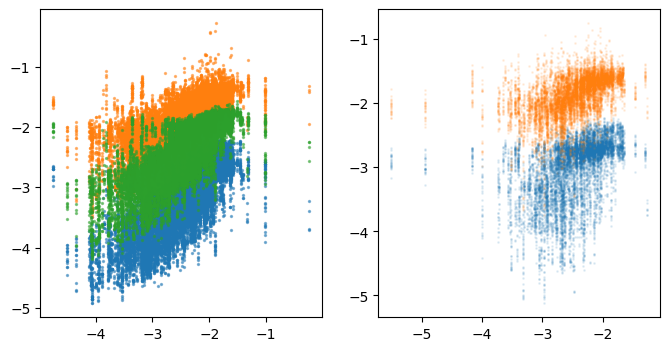

Train losses:  -0.834928537790592
Validation losses:  0.00585845002735203 RMSE: 0.004379920195788145


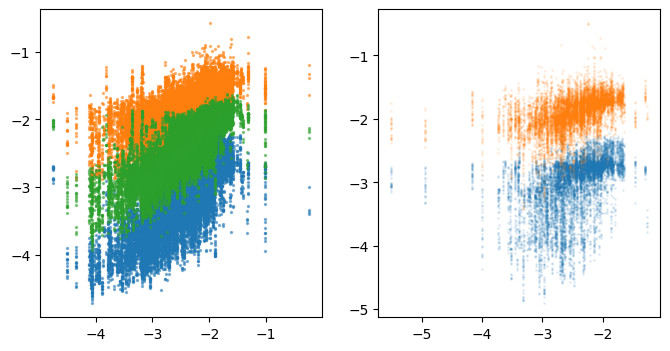

Train losses:  -0.847061235171098
Validation losses:  0.1390406455505978 RMSE: 0.00553472526371479


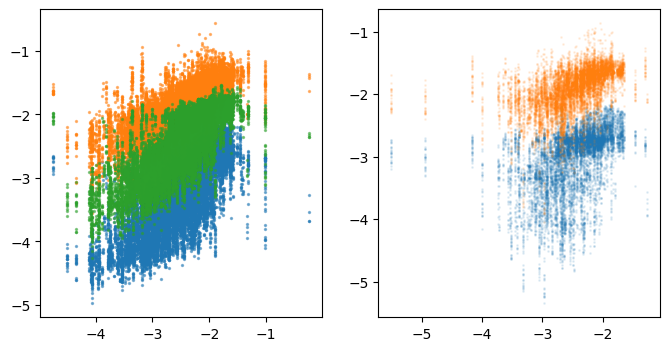

Train losses:  -0.8655545780291924
Validation losses:  0.11001307652755217 RMSE: 0.006160340737551451


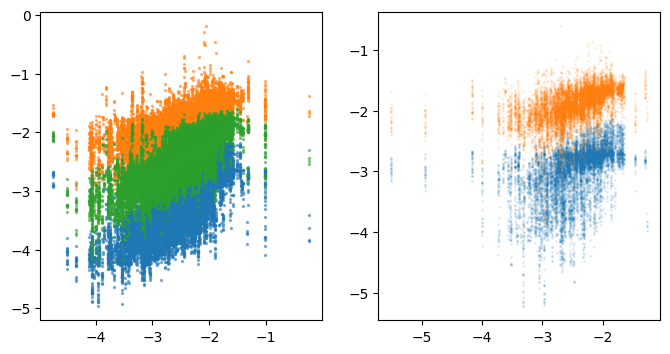

Train losses:  -0.8680007985005012
Validation losses:  0.37528719143434003 RMSE: 0.007568648550659418


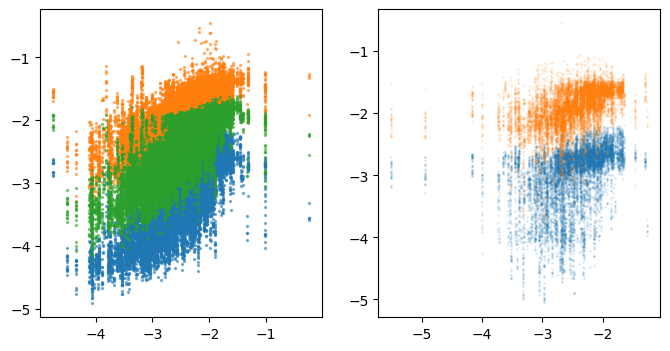

Train losses:  -0.8771425600235279
Validation losses:  0.42355327104980295 RMSE: 0.0061889588832855225


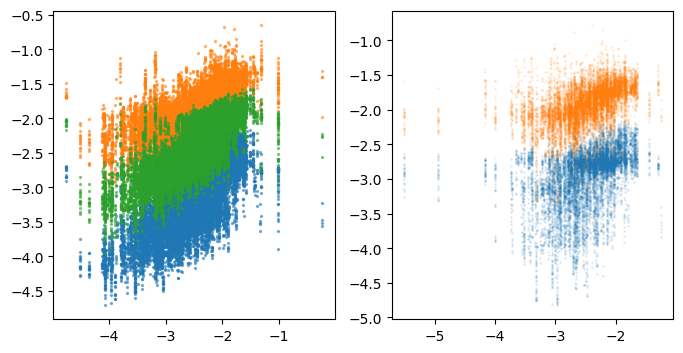

Train losses:  -0.8817410652454083
Validation losses:  0.46728374368765135 RMSE: 0.007360985968261957


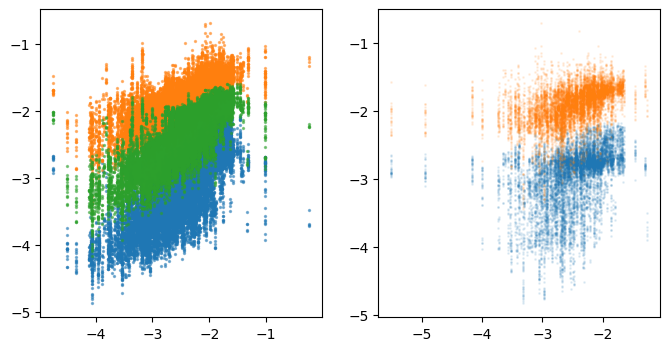

Train losses:  -0.8903705431864812
Validation losses:  0.4750026928430254 RMSE: 0.006083041429519653


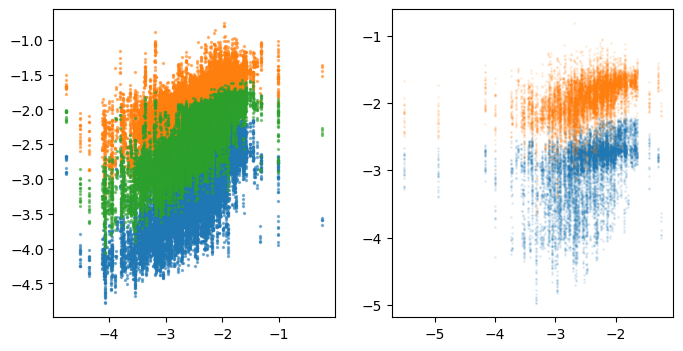

Train losses:  -0.8974429162649008
Validation losses:  0.4731003452431072 RMSE: 0.0044361017644405365


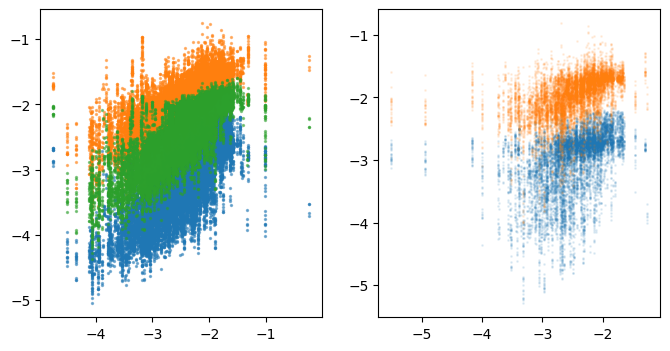

Train losses:  -0.9043692281612983
Validation losses:  0.39828520065004175 RMSE: 0.0072473506443202496


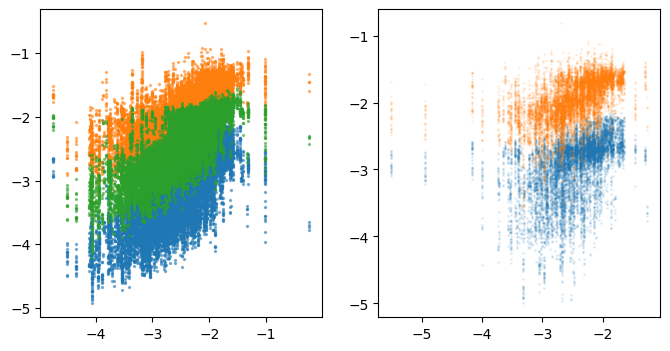

Train losses:  -0.9076317892624781
Validation losses:  0.395035558803515 RMSE: 0.005888108629733324


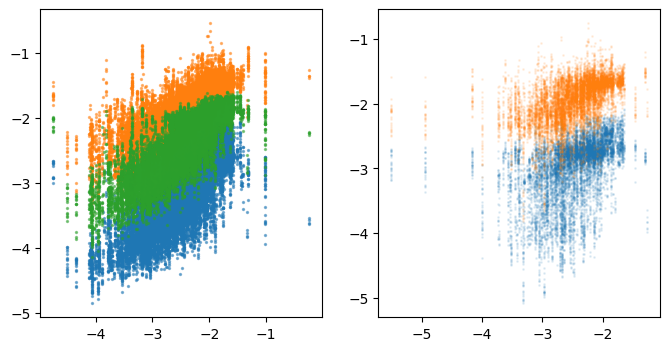

Train losses:  -0.9139912586945754
Validation losses:  0.2950052849271081 RMSE: 0.006354802753776312


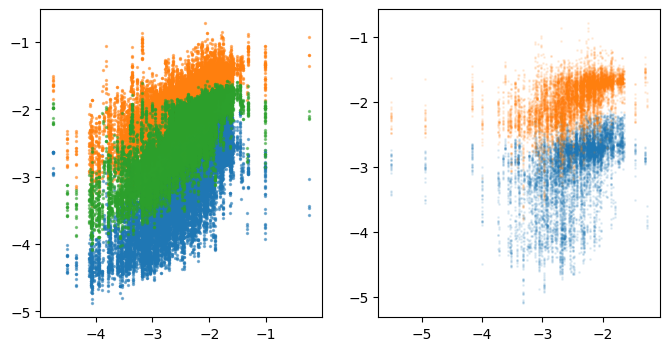

Train losses:  -0.9058255507395818
Validation losses:  0.5174054259603674 RMSE: 0.006615713704377413


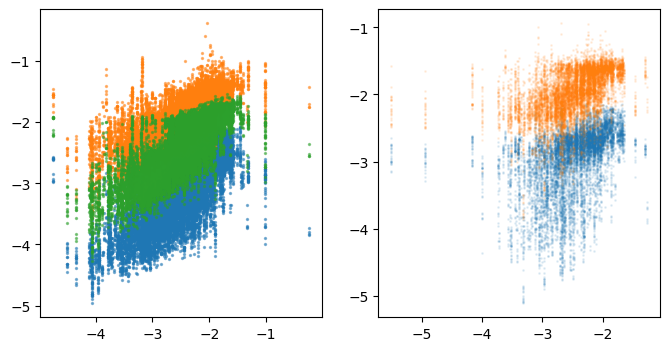

Train losses:  -0.9208961243812854
Validation losses:  0.5190103751691905 RMSE: 0.006270785350352526


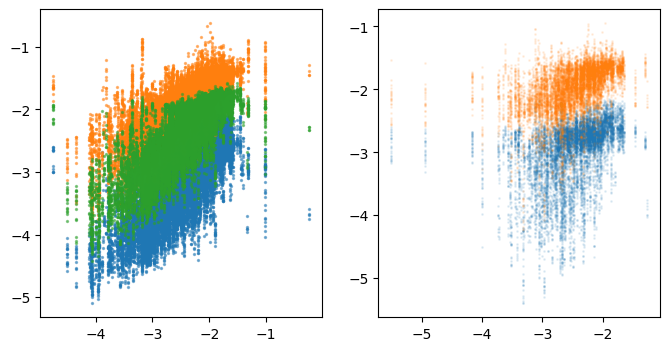

Train losses:  -0.9207801360350388
Validation losses:  0.5631799738515507 RMSE: 0.00760298315435648


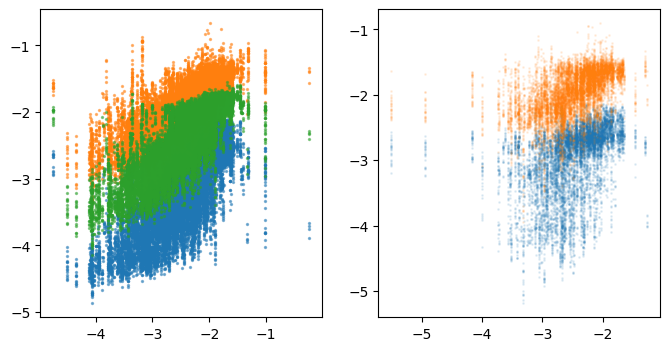

KeyboardInterrupt: 

In [388]:
%matplotlib inline

loss = TuckeyGandHloss(n_target_channels=1, gmax=1, hmax=1)

nn = nn.to(device=DEVICE)
train_torch = tuple([v.to(device=DEVICE) for v in train_torch])
test_torch = tuple([v.to(device=DEVICE) for v in test_torch])


for i_epoch in range(N_EPOCHS):
    epoch_loss = train_for_one_epoch(nn, loss, optimizer, scheduler,
                                     TensorDataset(*train_torch), TensorDataset(*test_torch))
    nn.eval()
    fig = plt.figure(figsize=(8, 4))
    with torch.no_grad():
        y_train = nn(train_torch[0])
        pred_ci95 = loss.predict_ci(y_train)
        pred_ci001 = loss.predict_ci(y_train, alpha=0.001)
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(train_torch[1].cpu(), pred_ci95[0].cpu(), alpha=0.5, s=2)
    ax.scatter(train_torch[1].cpu(), pred_ci95[1].cpu(), alpha=0.5, s=2)
    ax.scatter(train_torch[1].cpu(), pred_ci001[1].cpu(), alpha=0.5, s=2)
    with torch.no_grad():
        pred_ci95 = loss.predict_ci(nn(test_torch[0]))
    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(test_torch[1].cpu(), pred_ci95[0].cpu(), alpha=0.1, s=1)
    ax.scatter(test_torch[1].cpu(), pred_ci95[1].cpu(), alpha=0.1, s=1)
    plt.show()
    plt.pause(0.1)


Now we look at some predictions on the validation dataset

In [343]:
%matplotlib notebook

def plot_specific_block(block_name: str):
    data_block = test[test.Block_name == block_name].sort_values('Date')
    features_torch, targets_torch = convert_dataset_to_tensor(data_block, feature_names, 'YieldPerHec_log_n', 
                                                              True, *mean_std)
    nn.eval()
    with torch.no_grad():
        y_hat = nn(features_torch.to(device=DEVICE))
    ci = loss.predict_ci(y_hat, alpha=0.95)
    ci2 = loss.predict_ci(y_hat, alpha=0.99)
    ci3 = loss.predict_ci(y_hat, alpha=0.25)
    plt.figure()
    plt.plot(data_block.Date, np.exp(ci[0].cpu().numpy() - 2), 'k', label='95% level')
    plt.plot(data_block.Date, np.exp(ci[1].cpu().numpy() - 2), 'k')
    plt.plot(data_block.Date, np.exp(ci2[0].cpu().numpy() - 2), 'r', label='99% level')
    plt.plot(data_block.Date, np.exp(ci2[1].cpu().numpy() - 2), 'r')
    plt.plot(data_block.Date, np.exp(ci3[0].cpu().numpy() - 2), 'b')
    plt.plot(data_block.Date, np.exp(ci3[1].cpu().numpy() - 2), 'b', label='25% level')
    plt.scatter(data_block.Date.values[-1], data_block.YieldPerHec.values[-1], marker='*', c='g', s=50)
    plt.legend()
    plt.ylabel('Yield Per Hec')
    plt.title(f'Block {block_name}')

<IPython.core.display.Javascript object>


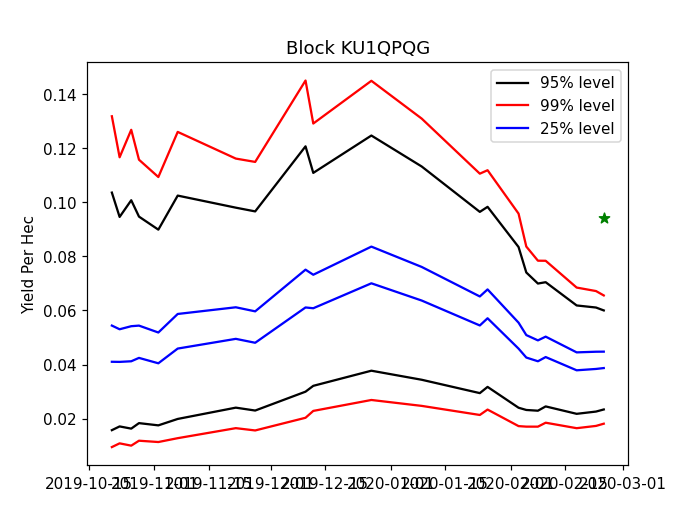

<IPython.core.display.Javascript object>


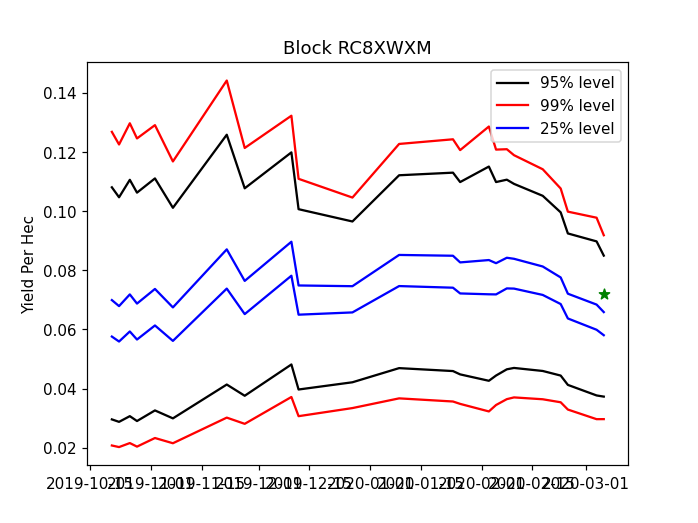

<IPython.core.display.Javascript object>


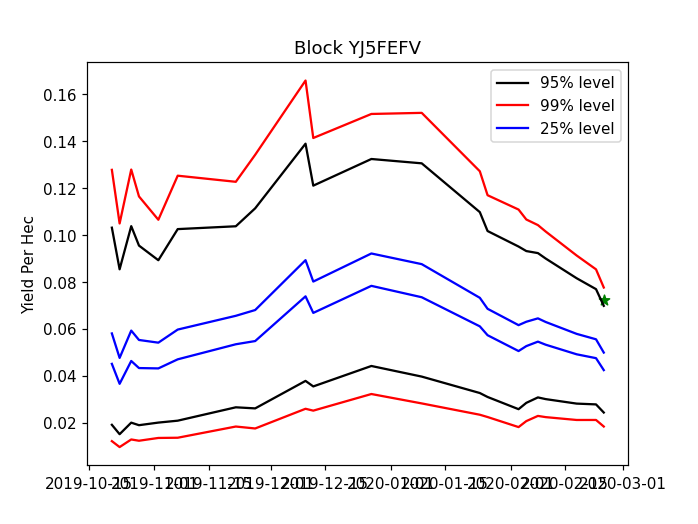

<IPython.core.display.Javascript object>


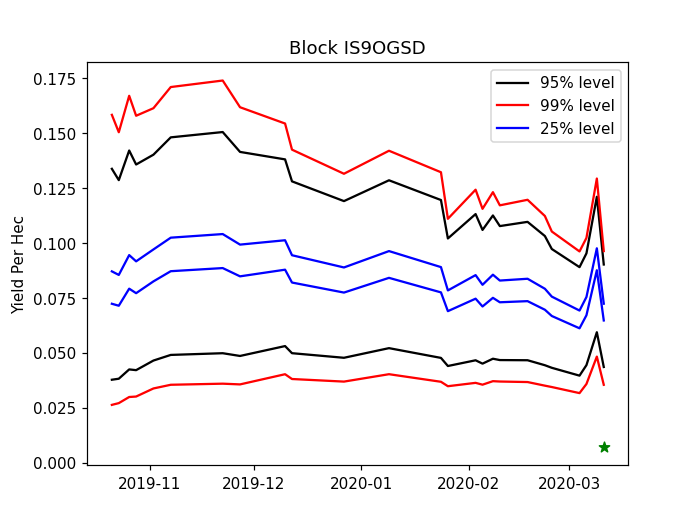

<IPython.core.display.Javascript object>


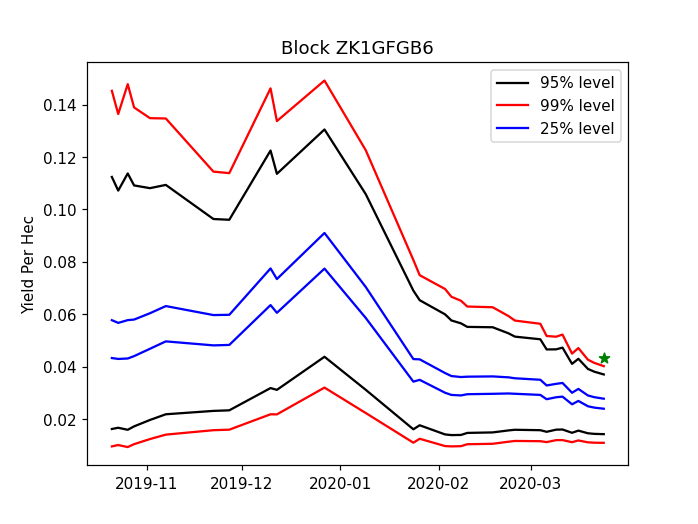

<IPython.core.display.Javascript object>


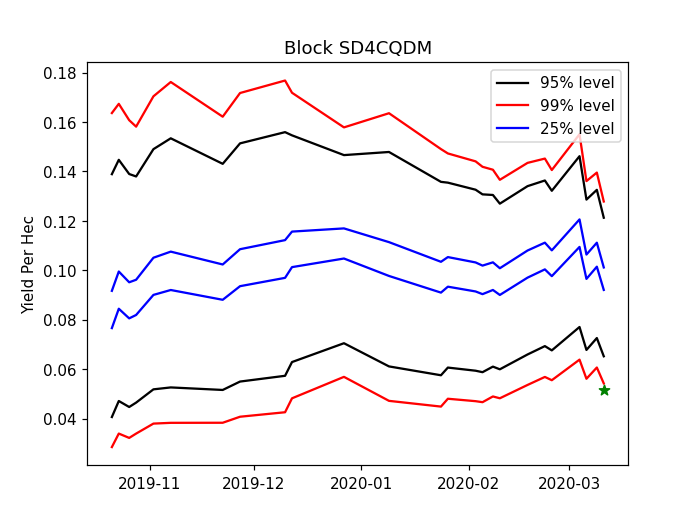

<IPython.core.display.Javascript object>


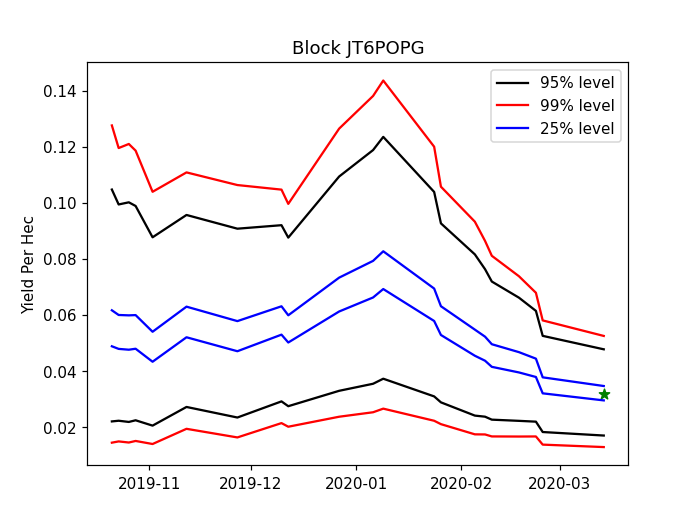

<IPython.core.display.Javascript object>


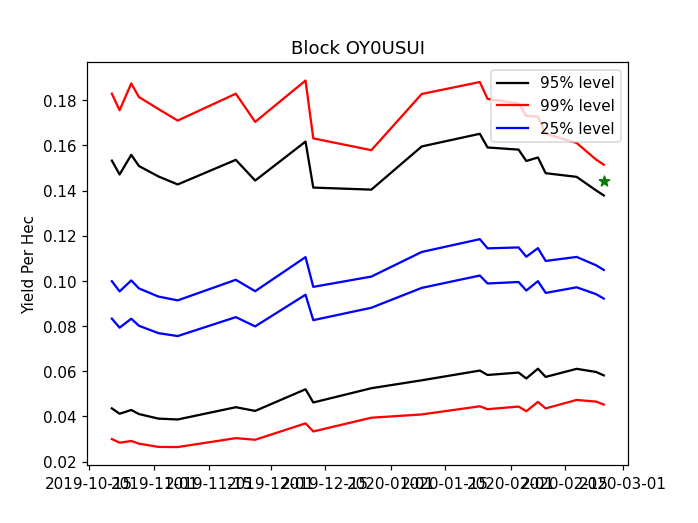

<IPython.core.display.Javascript object>


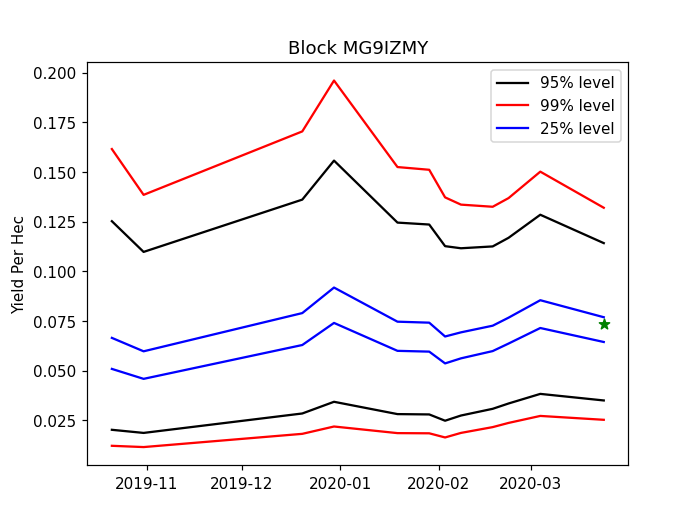

<IPython.core.display.Javascript object>


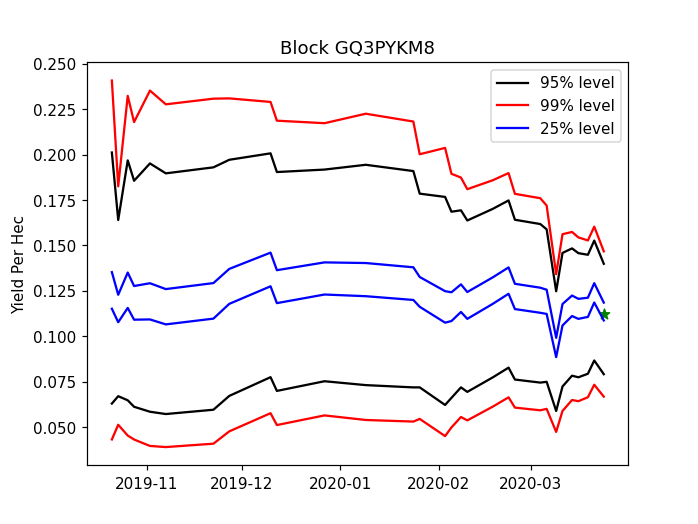

<IPython.core.display.Javascript object>


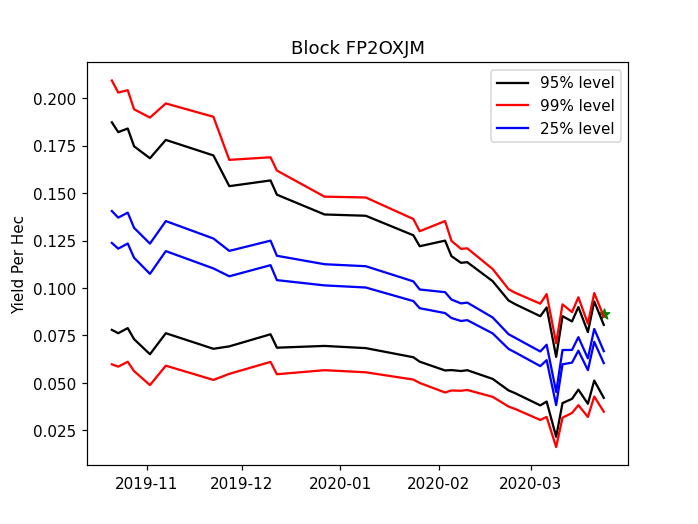

<IPython.core.display.Javascript object>


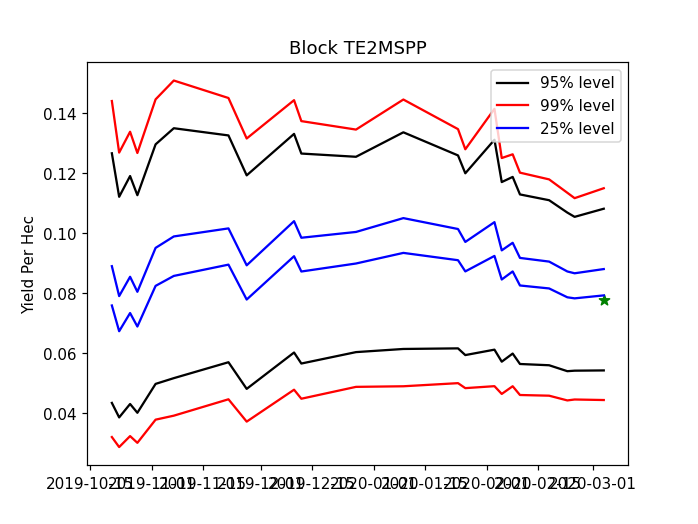

<IPython.core.display.Javascript object>


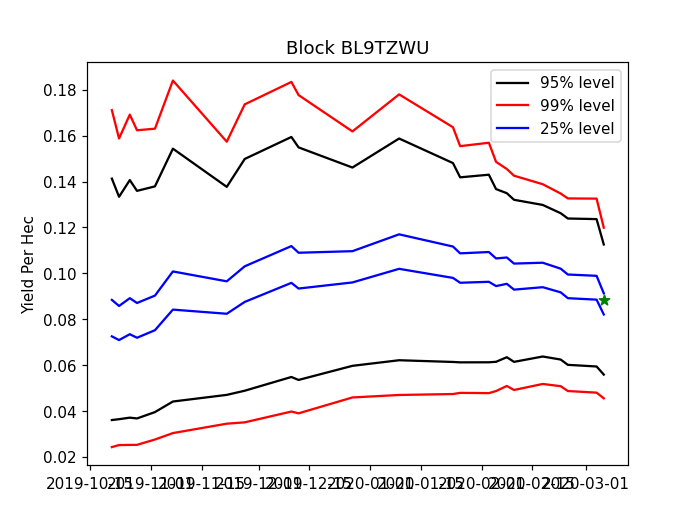

<IPython.core.display.Javascript object>


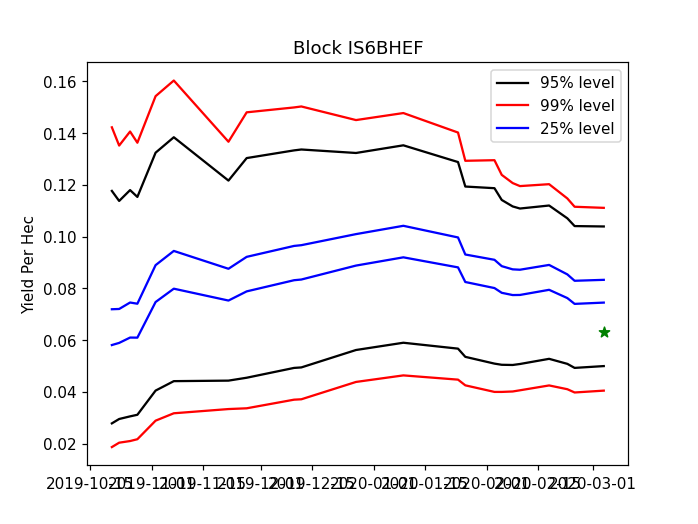

<IPython.core.display.Javascript object>


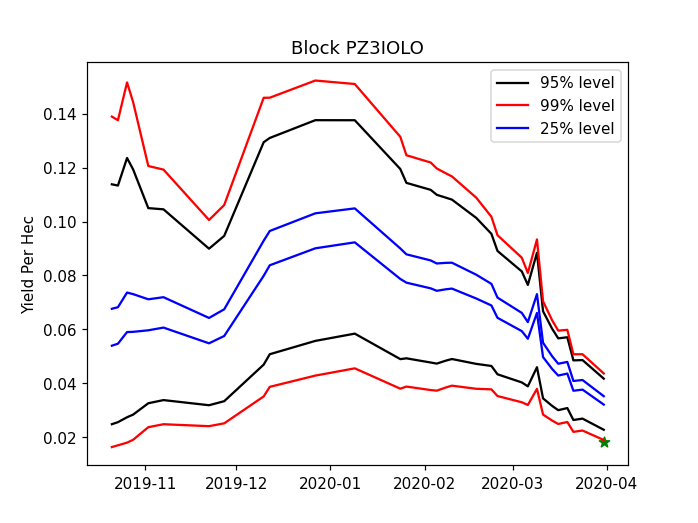

<IPython.core.display.Javascript object>


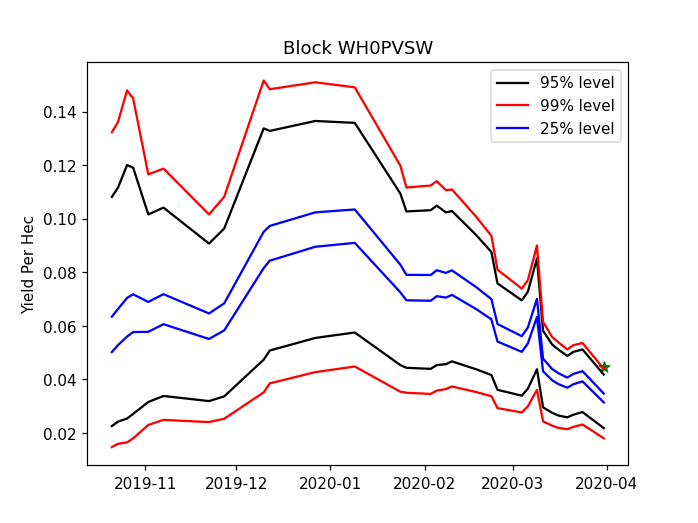

<IPython.core.display.Javascript object>


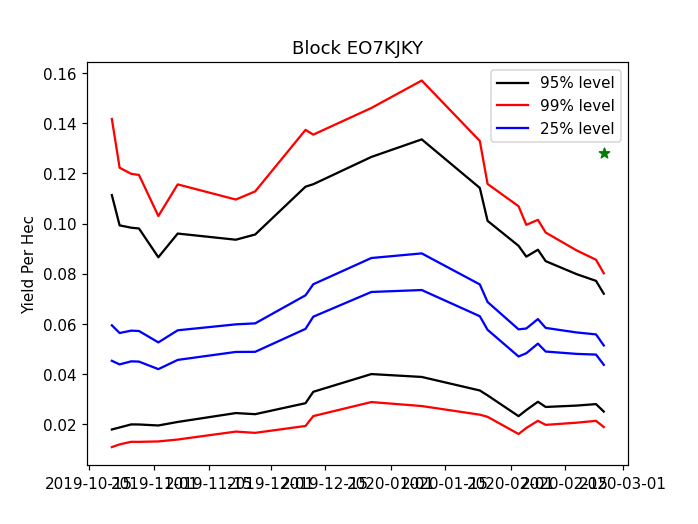

<IPython.core.display.Javascript object>


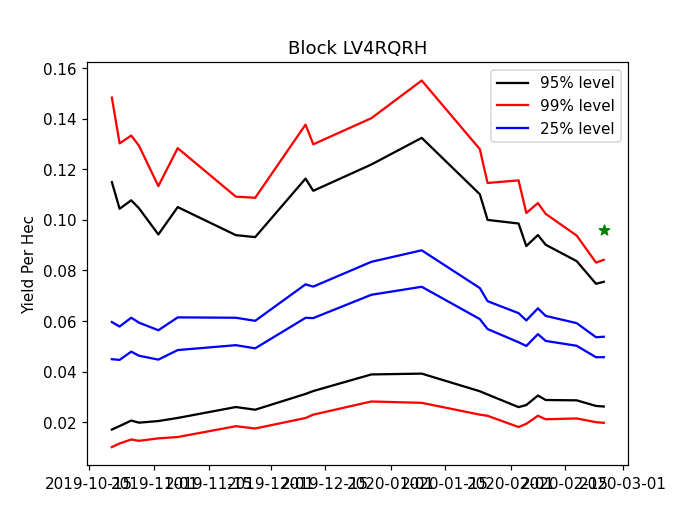

<IPython.core.display.Javascript object>


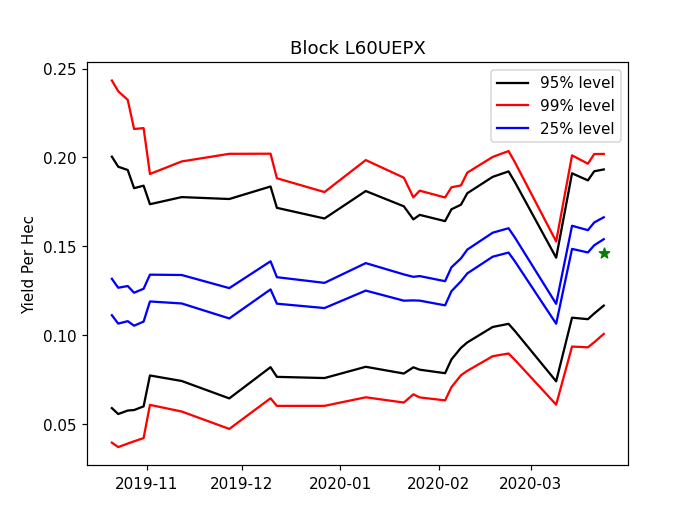

/tmp/2986144.1.all.q/ipykernel_136476/411757690.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>


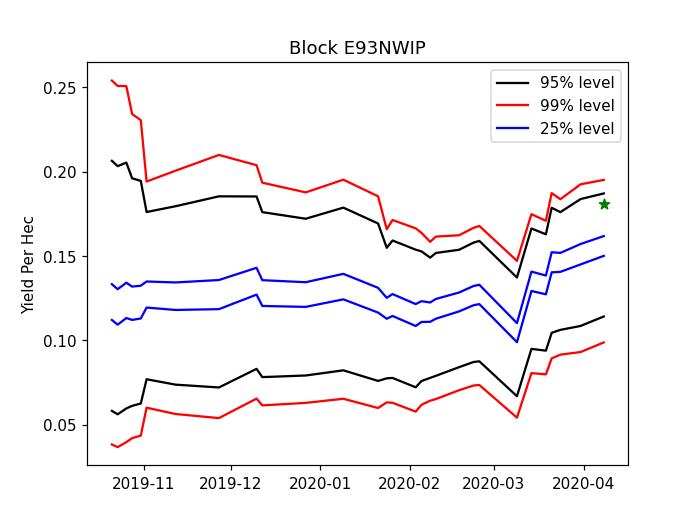

In [344]:
sel = crop_yield_data.Season == 2020
sel = np.logical_and(sel,  crop_yield_data.YieldPerHec)
for block_name in crop_yield_data[sel].Block_name[100:120]:
    plot_specific_block(block_name)

### Plot of residuals 

In [345]:
train = train.sort_values(['Block_name', 'Date'])
test = test.sort_values(['Block_name', 'Date'])


train = train.reset_index()
test = test.reset_index()

In [346]:
sel = train.index[train.TimeTo < 120].to_numpy()
sel_test = test.index[test.TimeTo < 120].to_numpy()

In [347]:
with torch.no_grad():
    pred_train = nn(train_torch[0][sel, :])
    pred_test = nn(test_torch[0][sel_test, :])
residuals_train = loss.residuals(pred_train, train_torch[1][sel, :]).cpu().numpy()
residuals_test = loss.residuals(pred_test, test_torch[1][sel_test, :]).cpu().numpy()

<IPython.core.display.Javascript object>


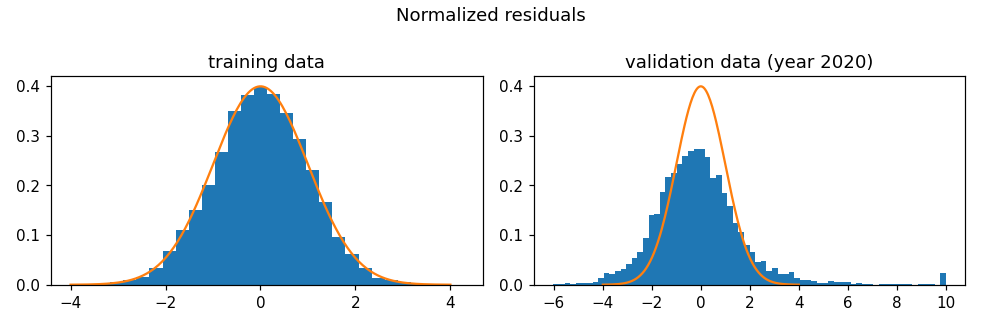

In [348]:
from scipy.stats import norm
xs = np.linspace(-4, 4, 200)
ys = norm.pdf(xs)

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 2, 1)
ax.hist(residuals_train, bins=30, density=True)
ax.plot(xs, ys)
ax.set_title('training data')
ax = fig.add_subplot(1, 2, 2)
ax.hist(residuals_test, bins=70, density=True)
ax.plot(xs, ys)
ax.set_title('validation data (year 2020)')
fig.suptitle('Normalized residuals')
fig.tight_layout()



### Plot of some predictions

In [340]:
train = train.sort_values('Date')
groups = train.groupby(['Block_name', 'Season'])

In [341]:
groups = list([groups.get_group(x) for x in groups.groups])

/tmp/2986144.1.all.q/ipykernel_136476/169609183.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


<IPython.core.display.Javascript object>


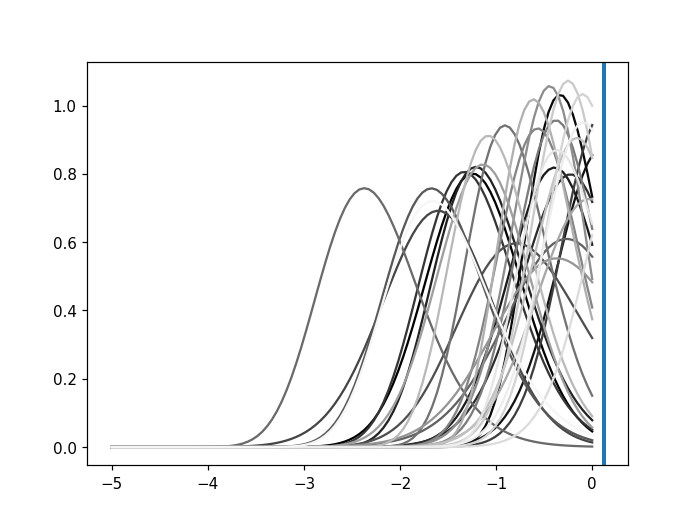

In [342]:
%matplotlib notebook

from tukey.utils import compute_pdf_tukey

fig = plt.figure()
xs = torch.linspace(-5, 0, 100)
pred_train = pred_train.cpu()
mu, beta, g, h = loss.predict(pred_train)

group = groups[10]
n = len(group.index)

for i, j in enumerate(group.index):
    pdf = compute_pdf_tukey(xs, g[j], h[j], mu[j], 1 / beta[j])
    plt.plot(xs, pdf, color=(i / n, i / n, i / n))
    plt.axvline(group.YieldPerHec_log.iloc[0])

In [176]:
group

level_0  index  Unnamed: 0 Vineyard_name Block_name  Season       Date  \
1596    15531  33703       33703           L14    C70UBXH    2019 2018-10-21   
1597    15996  33541       33541           L14    C70UBXH    2019 2018-10-23   
1598    16293  33326       33326           L14    C70UBXH    2019 2018-11-05   
1599    16857  32894       32894           L14    C70UBXH    2019 2018-11-10   
1600    17231  32528       32528           L14    C70UBXH    2019 2018-11-12   
1601    17473  32948       32948           L14    C70UBXH    2019 2018-11-15   
1602    17551  33433       33433           L14    C70UBXH    2019 2018-11-17   
1603    18019  32366       32366           L14    C70UBXH    2019 2018-11-20   
1604    18634  33595       33595           L14    C70UBXH    2019 2018-12-30   
1605    19111  32625       32625           L14    C70UBXH    2019 2019-01-01   
1606    19735  33218       33218           L14    C70UBXH    2019 2019-01-04   
1607    19916  33002       33002           L14    C70UBXH    2019 2019-01-14   
1608    20190  33164       33164           L14    C70UBXH    2019 2019-01-16   
1609    20790  32289       32289           L14    C70UBXH    2019 2019-01-19   
1610    21347  32474       32474           L14    C70UBXH    2019 2019-01-21   
1611    21427  33487       33487           L14    C70UBXH    2019 2019-01-24   
1612    21787  33649       33649           L14    C70UBXH    2019 2019-01-26   
1613    22551  33272       33272           L14    C70UBXH    2019 2019-02-03   
1614    22790  32787       32787           L14    C70UBXH    2019 2019-02-08   
1615    23076  32420       32420           L14    C70UBXH    2019 2019-02-10   
1616    23631  33110       33110           L14    C70UBXH    2019 2019-02-13   
1617    23991  32679       32679           L14    C70UBXH    2019 2019-02-18   
1618    24258  32733       32733           L14    C70UBXH    2019 2019-02-20   
1619    24796  33056       33056           L14    C70UBXH    2019 2019-02-25   
1620    25125  32236       32236           L14    C70UBXH    2019 2019-02-28   
1621    25791  32841       32841           L14    C70UBXH    2019 2019-03-02   
1622    25953  33380       33380           L14    C70UBXH    2019 2019-03-05   
1623    26436  32582       32582           L14    C70UBXH    2019 2019-03-12   

         Variety  NDVImean     NDVIsum  NDWImean     NDWIsum  NDVIRemean  \
1596  Chardonnay  0.623881  194.027122  0.091716   28.523629    0.281513   
1597  Chardonnay  0.636938  198.087611  0.113421   35.273943    0.302147   
1598  Chardonnay  0.687674  213.866703  0.182640   56.800985    0.351977   
1599  Chardonnay  0.746706  232.225567  0.259549   80.719841    0.394068   
1600  Chardonnay  0.729982  227.024254  0.240355   74.750319    0.397244   
1601  Chardonnay  0.663892  206.470493  0.234013   72.778097    0.309911   
1602  Chardonnay  0.718362  223.410597  0.234262   72.855466    0.367084   
1603  Chardonnay  0.755820  235.059945  0.271919   84.566955    0.400390   
1604  Chardonnay  0.815892  253.742317  0.339393  105.551119    0.457186   
1605  Chardonnay  0.836513  260.155471  0.317007   98.589098    0.517488   
1606  Chardonnay  0.868420  270.078669  0.402279  125.108826    0.539888   
1607  Chardonnay  0.901256  280.290500  0.458959  142.736210    0.620298   
1608  Chardonnay  0.880078  273.704222  0.419360  130.421039    0.588505   
1609  Chardonnay  0.895476  278.493175  0.457602  142.314185    0.600673   
1610  Chardonnay  0.843628  262.368189  0.335775  104.426131    0.526929   
1611  Chardonnay  0.653783  203.326556  0.313348   97.451150    0.264840   
1612  Chardonnay  0.771640  239.980163  0.283202   88.075690    0.407810   
1613  Chardonnay  0.769835  239.418713  0.294879   91.707516    0.376332   
1614  Chardonnay  0.738729  229.744869  0.266960   83.024514    0.347585   
1615  Chardonnay  0.780533  242.745888  0.305497   95.009600    0.408400   
1616  Chardonnay  0.777285  241.735684  0.300574   93.478501    0.398293   
1617  Chardon